In [1]:
import os
import sys

src_dir = os.path.abspath('../src')
if src_dir not in sys.path:
    sys.path.append(src_dir)

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tqdm

from ann_solo import reader, spectral_library, spectrum_match
from ann_solo.config import config
from ann_solo.spectrum import process_spectrum, spectrum_to_vector

In [3]:
tqdm.tqdm = tqdm.tqdm_notebook

# plot styling
plt.style.use(['seaborn-white', 'seaborn-paper'])
plt.rc('font', family='serif')
sns.set_palette('Set1')
sns.set_context('paper', font_scale=1.3)    # single-column figure

In [4]:
config_filename = '../../bin/ann-solo/iprg2012.ini'
splib_filename = '../../data/interim/iprg2012/human_yeast_targetdecoy.splib'
mgf_filename = '../../data/external/iprg2012/iPRG2012.mgf'

In [5]:
config.parse(f'--config {config_filename} dummy.splib dummy.mgf dummy.mztab')

In [6]:
ssms = reader.read_mztab_ssms(
    '../../data/processed/iprg2012/brute_force/bf_oms.mztab')

In [7]:
query_spectra = {int(spectrum.identifier): process_spectrum(spectrum, False)
                 for spectrum in reader.read_mgf(mgf_filename)
                 if spectrum.precursor_charge is not None}

In [8]:
with reader.SpectralLibraryReader(splib_filename) as lib_reader:
    library_spectra = {}
    for accession in ssms['accession']:
        spectrum = lib_reader.get_spectrum(accession, True)
        library_spectra[int(spectrum.identifier)] = spectrum

In [9]:
bin_widths = [1.0, 0.4, 0.2, 0.1, 0.04, 0.02]
hash_len = [100, 200, 400, 800, 1600, None]
scores = {'dot': [], 'shifted_dot': [],
          **{(bw, hl): [] for bw in bin_widths for hl in hash_len}}

for query_id, library_id in tqdm.tqdm(ssms['accession'].iteritems(),
                                      unit='SSMs'):
    if query_id in query_spectra:
        query_spectrum = query_spectra[query_id]
        library_spectrum = library_spectra[library_id]
        
        for key, results in scores.items():
            if 'dot' in key:
                scores[key].append(spectrum_match.get_best_match(
                    query_spectrum, [library_spectrum],
                    config.fragment_mz_tolerance, 'shifted' in key)[1])
            else:
                query_vector = spectrum_to_vector(
                    query_spectrum, config.min_mz, config.max_mz, *key)
                library_vector = spectrum_to_vector(
                    library_spectrum, config.min_mz, config.max_mz, *key)
                scores[key].append(np.dot(query_vector, library_vector))

for key, val in scores.items():
    scores[key] = np.asarray(val)

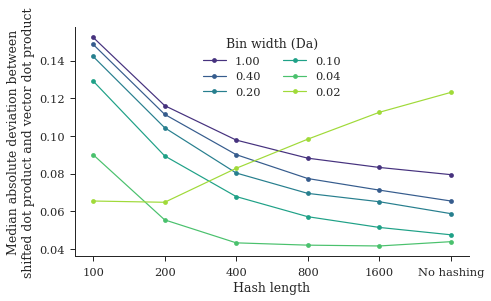

In [10]:
with sns.color_palette('viridis'):
    width = 7
    height = width / 1.618    # golden ratio
    fig, ax = plt.subplots(figsize=(width, height))

    xticks = np.arange(len(hash_len))
    for bw in bin_widths:
        mads = []
        iqr = []
        for hl in hash_len:
            diff = np.abs(scores['shifted_dot'] - scores[(bw, hl)])
            mads.append(np.median(diff))
#             iqr.append(np.percentile(diff, [25, 75]))
        ax.plot(xticks, mads, label=f'{bw:.2f}', marker='o')
#         ax.errorbar(xticks, mads, yerr=np.asarray(err).T,
#                     label=f'{bw:.2f}', marker='o')

    ax.set_xticks(xticks)
    ax.set_xticklabels(hash_len[:-1] + ['No hashing'])

    ax.set_xlabel('Hash length')
    ax.set_ylabel('Median absolute deviation between\n'
                  'shifted dot product and vector dot product')

    ax.legend(ncol=2, title='Bin width (Da)')

    sns.despine()

    plt.tight_layout()

    plt.savefig('hash_mad.pdf', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

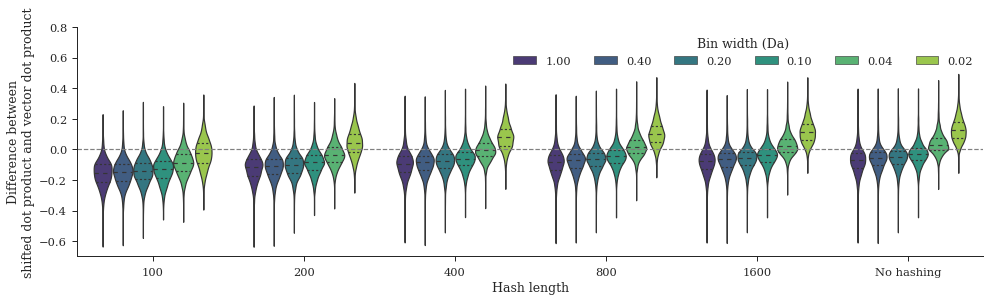

In [11]:
with sns.color_palette('viridis'):
    width = 7
    height = width / 1.618    # golden ratio
    fig, ax = plt.subplots(figsize=(2 * width, height))

    diffs, hls, bws = [], [], []
    num_ssm = len(scores['shifted_dot'])
    for bw in bin_widths:
        for hl in hash_len:
            diffs.extend(scores['shifted_dot'] - scores[(bw, hl)])
            hls.extend([hl if hl is not None else 'No hashing'] * num_ssm)
            bws.extend([f'{bw:.2f}'] * num_ssm)
    diff_df = pd.DataFrame({'hl': hls, 'diff': diffs, 'bw': bws})
    
    sns.violinplot(x='hl', y='diff', hue='bw', data=diff_df,
                   hue_order=[f'{bw:.2f}' for bw in bin_widths],
                   inner='quartiles', ax=ax)
    
    ax.axhline(0, ls='--', color='gray')
    
    ax.set_ylim(-0.7, 0.8)
    
    ax.set_xlabel('Hash length')
    ax.set_ylabel('Difference between\n'
                  'shifted dot product and vector dot product')

    ax.legend(ncol=6, title='Bin width (Da)', loc='upper right')

    sns.despine()

    plt.tight_layout()
    
    plt.savefig('hash_violin.pdf', dpi=300, bbox_inches='tight')

    plt.show()
    plt.close()

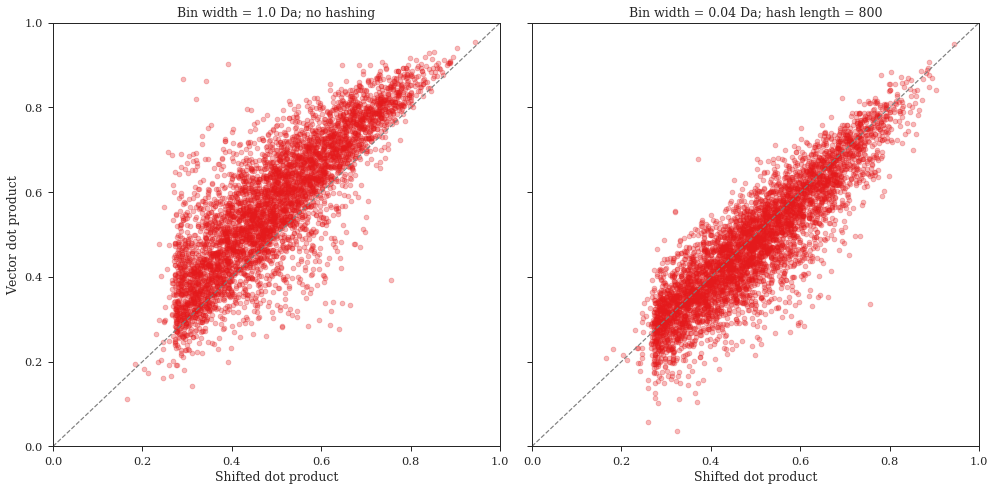

In [12]:
width = 7
height = width
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True,
                         figsize=(2 * width, height))

bw_low, bw_high, hl = 1.0, 0.04, 800
axes[0].scatter(scores['shifted_dot'], scores[(bw_low, None)], alpha=0.3)
axes[1].scatter(scores['shifted_dot'], scores[(bw_high, hl)], alpha=0.3)

for ax in axes:
    ax.plot([0, 1], [0, 1], ls='--', color='gray')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

axes[0].set_ylabel('Vector dot product')
axes[0].set_xlabel('Shifted dot product')
axes[1].set_xlabel('Shifted dot product')

axes[0].set_title(f'Bin width = {bw_low} Da; no hashing')
axes[1].set_title(f'Bin width = {bw_high} Da; hash length = {hl}')

plt.tight_layout()

plt.savefig('hash_dot.pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.close()